[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# YOLOv8 Tracking and Counting

---

[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/OS5qI9YBkfk)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/yolov8-tracking-and-counting/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/notebooks)

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## ⚠️ Disclaimer

This notebook uses legacy versions of ByteTrack and Supervision. To be up to date, use our updated [notebook](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-track-and-count-vehicles-with-yolov8-and-supervison.ipynb).

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the [blog post](https://blog.roboflow.com/yolov8-tracking-and-counting/) on how to train YOLOv8 Tracking and Counting, concurrently.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Download video
- Install YOLOv8
- Install ByteTrack
- Install Roboflow Supervision
- Tracking utils
- Load pre-trained YOLOv8 model
- Predict and annotate single frame
- Predict and annotate whole video

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon Jun 19 04:01:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/close.MOV"

## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **23.01.2023** with version **YOLOv8.0.17**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.1/107.7 GB disk)


## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [ ]:
# settings
MODEL = "/content/best.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]


0: 384x640 5 cars, 475.3ms
Speed: 14.2ms preprocess, 475.3ms inference, 24.9ms postprocess per image at shape (1, 3, 384, 640)


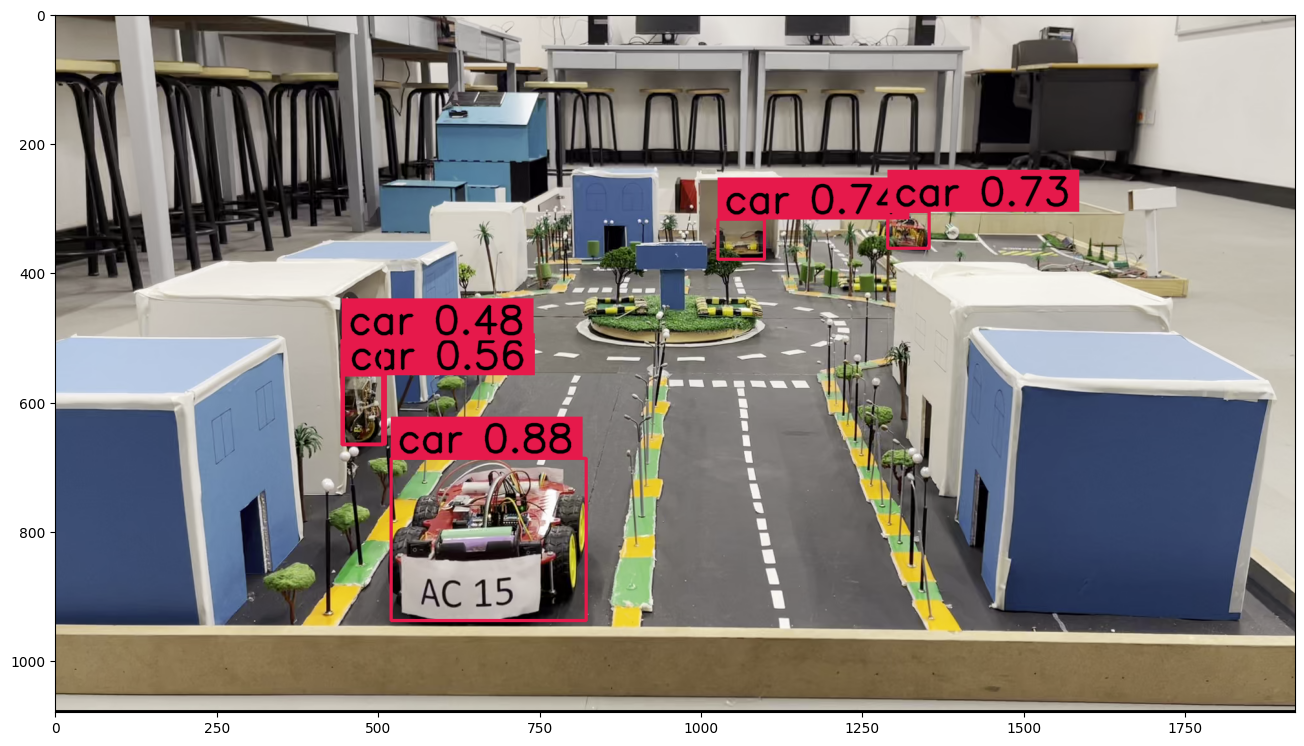

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))